# TLS example run

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import defect_map_handling
import tof_calculator
import dictionary_former

In [12]:
class HyperbolaFitTLS():
    def __init__(self):
        self.defmap = None # Base of the defect map
        
    def find_peaks(self, data, dz):
        # Copy the input data
        if data.ndim == 1:
            ascans = np.array([data])
        else:
            ascans = np.array(data)
            
        self.z_peak = np.zeros(ascans.shape[1])
        for idx in range(ascans.shape[1]):
            curr_ascan = ascans[:, idx]
            self.z_peak[idx] = np.where(curr_ascan==abs(curr_ascan).max())[0][0]*dz
        
    def get_defect_map(self):
        return self.defmap


class HyperbolaFitTLS2D(HyperbolaFitTLS):
    """ Estimate a defect position by fitting the hyperbola to the measurement data. 
    In this class, the coefficients of the hyperbola polynomial is to be determined from the 
    available scan position, x, and the peak position of the measurement data, z_peak. 
    
    z = [z_peak_1**2, z_peak_2**2, z_peak_3**2, etc]
    X = coefficient matrix containing 1, xi and xi**2 as its row
      = [[1, x1, x1**2], [1, x2, x2**2], [1, x3, x3**2], etc...]
    w = the LS/TLS solution to find
      = [w0, w1, w2]
      where
          w2 = (z_def/curveture)**2
          w1 = -2* x_def* u2
          w0 = u2* (u1**2/ (4*u2**2) + curveture**2)
      -> this leads to 
          x_def = - w1/ (2* w2)
          z_def = np.sqrt(w0 - w1**2/ (4* w2))
          curvature = np.sqrt(u0 - u1**2/(4*u2**2))
    """
    def __init__(self):
        self.z_peak = None
        self.x_def = None
        self.z_def = None
            

    def solve_TLS(self, x_track):
        """      
        z \approx X* w --- correction ---> z + dz = (X + dX)* w
            => [X+dX z+dz]* [w^T -1]^T = zeros(K) w/ K = # of measurement data
            => [w^T -1]^T lies in the nullspace of [X+dX z+dz]

        [Xz] = U* S* Vh = [U1 u2]* diag(S1, s2)* [V1 v2]^T w/ full rank = 4
        -> Correction of the matrix [Xz] according to the TLS
        [X+dX z+dz] = U1* S1* V1h w/ the rank = 3 
            => v2 is in the nullspace of [X+dX z+dz]
            => [w^T -1]^T = alpha* V2h => w = -1/Vh[-1, -1]* Vh[-1, :-1] 
        """
        X = np.zeros((len(x_track), 3))
        X[:, 0] = 1
        for idx in range(len(x_track)):
            X[idx, 1] = x_track[idx]
            X[idx, 2] = x_track[idx]**2
        # Setting for z
        z = self.z_peak**2
        # Concatenate [Xz]
        Xz = np.concatenate((X, np.array([z]).T), axis = 1)
        # SVD of Xz
        U, S, Vh = np.linalg.svd(Xz, full_matrices = True)
        # Determine the w
        w = -1/Vh[-1, -1]* Vh[-1, :-1]
        # Calculate xdef, zdef
        self.x_def = - w[1]/ (2* w[2])
        self.z_def = np.sqrt(w[0] - w[1]**2/(4* w[2]))
    
    def convert_to_defect_map(self, Nx, Nz, dx, dz):
        p_def = np.array([self.x_def, self.z_def])
        dmh = defect_map_handling.DefectMapSingleDefect2D(p_def, Nx, Nz, dx, dz)
        dmh.generate_defect_map()
        self.defmap = dmh.get_defect_map()
     
    def estimate_defect_position(self, x_track, Nx, Nz, dx, dz):
        self.solve_TLS(x_track)
        self.convert_to_defect_map(Nx, Nz, dx, dz)

### Parameter setting

In [13]:
# Parameters
Nx = 20 # limited due to the opening angle
Nz = 200
Nt = Nz
c0 = 6300 #[m/S]
fS = 80*10**6 #[Hz] 
fC = 5*10**6 #[Hz] 
alpha = 20*10**12 #[Hz]**2
dx = 0.5*10**-3 #[m]
dz = 0.5* c0/(fS)
wavelength = 1.26* 10**-3 # [m]
# defect position: p_defect
p_def_idx = np.array([10, 91])
p_def = np.array([p_def_idx[0]*dx, p_def_idx[1]*dz])
# defect map: defmap
dmh = defect_map_handling.DefectMapSingleDefect2D(p_def, Nx, Nz, dx, dz)
dmh.generate_defect_map()
defmap_true = dmh.get_defect_map()

### ToF calculation

In [14]:
p_scan = np.zeros((Nx, 2))
p_scan[:, 0] = np.arange(Nx)*dx
tofcalc = tof_calculator.ToFforDictionary2D(c0, Nx, Nz, dx, dz, p_scan)
tofcalc.calculate_tof(calc_grad = False)
tof = tofcalc.get_tof()
# grad_tof = tofcalc.get_grad_tof()

### Data generation

In [15]:
dformer = dictionary_former.DictionaryFormer(Nt, fS, fC, alpha)
dformer.generate_dictionary(tof)
H = dformer.get_SAFT_matrix()
a_true = np.dot(H, defmap_true)
A_true = np.reshape(a_true, (Nt, p_scan.shape[0]), 'F')

### Position manipulation

In [16]:
mu, sigma = 0, 1.0
seed = 0
# Initialization of np.random
np.random.seed(seed)
# Tracking error w/ the normal distribution
e_track = wavelength* np.random.normal(mu, sigma, p_scan.shape[0])
p_track = p_scan + np.array([e_track, 0])

In [17]:
x_track = p_track[:, 0]
hypfit = HyperbolaFitTLS2D()
hypfit.find_peaks(A_true, dz)
hypfit.estimate_defect_position(p_scan[:, 0], Nx, Nz, dx, dz)
defmap_est = hypfit.get_defect_map()

In [ ]:
np.array([hypfit.x_def, hypfit.z_def])

In [18]:
a_track = np.dot(H, defmap_true)
A_track = np.reshape(a_true, (Nt, p_scan.shape[0]), 'F')

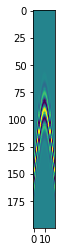

In [19]:
plt.imshow(A_track)